<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/FastInpaintingNet-Jan25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
import numpy as np

class FastInpaintingNet(nn.Module):
    def __init__(self):
        super(FastInpaintingNet, self).__init__()

        # Simplified architecture with fewer layers but effective feature extraction
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Middle blocks with dilated convolutions for larger receptive field
        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x, mask):
        # Concatenate input image and mask
        x = torch.cat([x, mask], dim=1)
        # Encode
        x = self.encoder(x)
        # Process
        x = self.middle(x)
        # Decode
        x = self.decoder(x)
        return x

def setup_data(root_dir='./data', img_size=128, batch_size=32):
    """
    Setup data pipeline using a smaller dataset (CIFAR-10 instead of CelebA-HQ)
    CIFAR-10 is much smaller and faster to process
    """
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 dataset
    dataset = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)

    # Use a smaller subset for faster training
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

def create_fast_mask(image):
    """Create a simpler rectangular mask"""
    _, h, w = image.shape
    mask = torch.ones_like(image)

    # Create a centered rectangle mask
    mask_h = h // 3
    mask_w = w // 3
    top = (h - mask_h) // 2
    left = (w - mask_w) // 2

    mask[:, top:top+mask_h, left:left+mask_w] = 0
    return mask

def train_fast_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    """
    Optimized training loop with faster convergence
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()

    # Learning rate scheduler for faster convergence
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            images = batch[0].to(device)  # For CIFAR-10, batch is (images, labels)
            masks = torch.stack([create_fast_mask(img) for img in images]).to(device)
            masked_images = images * masks

            optimizer.zero_grad()
            outputs = model(masked_images, masks)
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch[0].to(device)
                masks = torch.stack([create_fast_mask(img) for img in images]).to(device)
                masked_images = images * masks

                outputs = model(masked_images, masks)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Update learning rate
        scheduler.step(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_fast_inpainting.pth')

        # Clear cache
        torch.cuda.empty_cache()

if __name__ == "__main__":
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create data loaders with smaller image size and batch size
    train_loader, val_loader, test_loader = setup_data(img_size=128, batch_size=32)

    # Create and train model
    model = FastInpaintingNet()
    train_fast_model(model, train_loader, val_loader, num_epochs=10, device=device)

Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


KeyboardInterrupt: 

Using device: cuda
Files already downloaded and verified


<ipython-input-2-05b5a61f1f06>:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_fast_inpainting.pth', map_location=device))


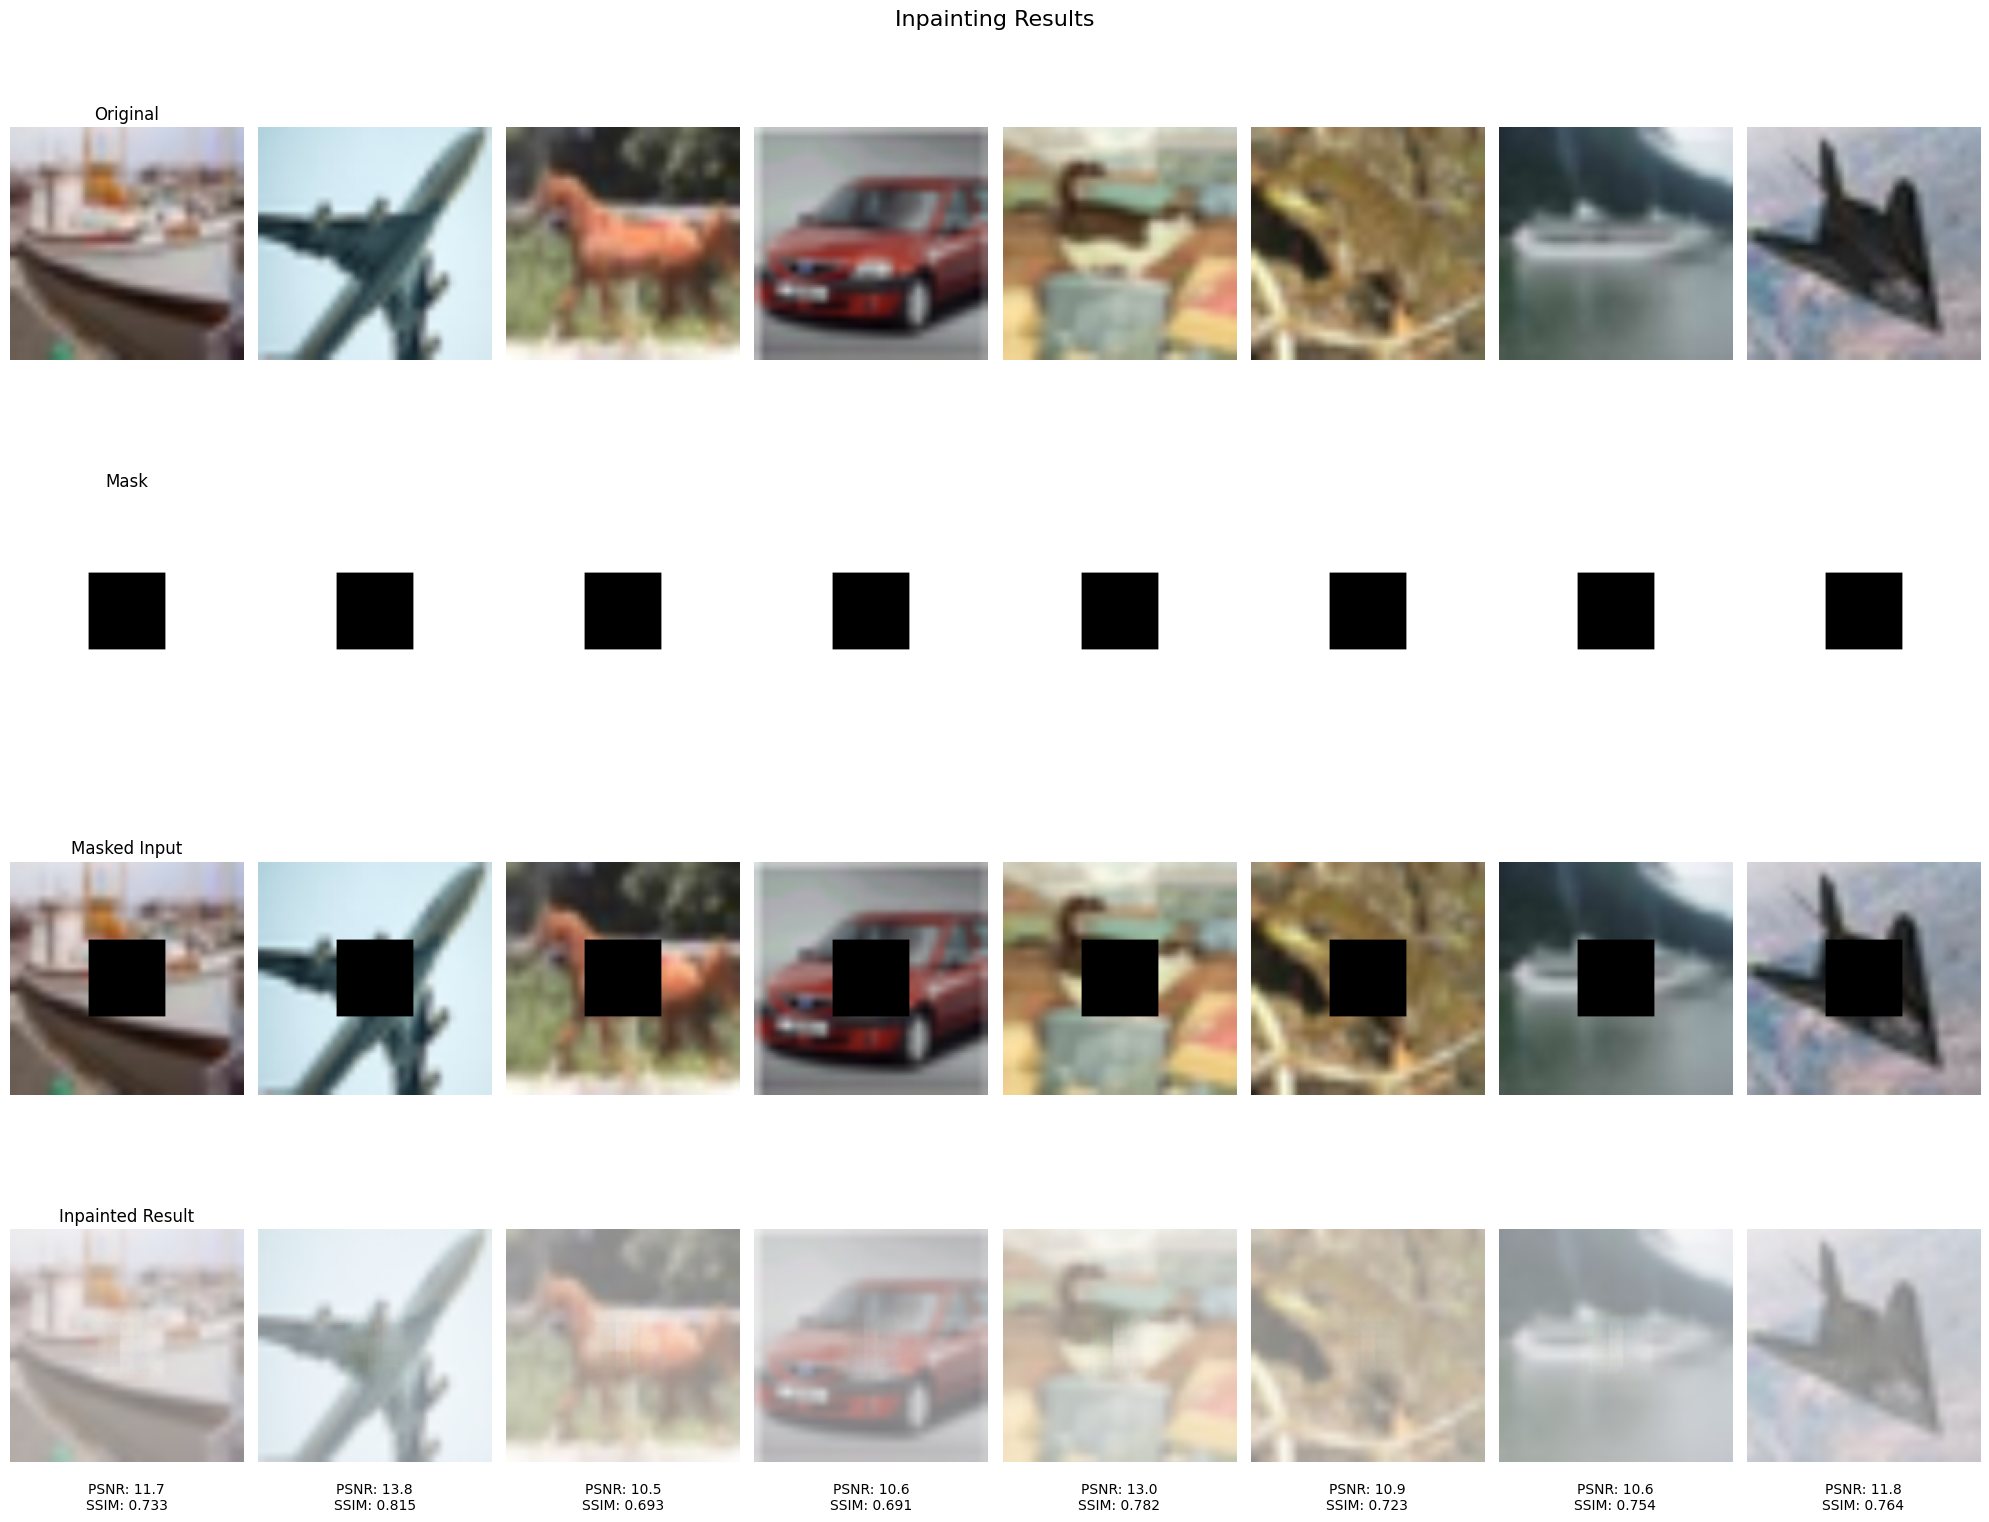


=== Inpainting Model Evaluation ===

Image Quality Metrics (averaged over 8 samples):
PSNR: 11.61 dB (±1.14)
SSIM: 0.744 (±0.040)

Performance Metrics:
Average inference time: 13.3ms (±33.0ms)

Model Performance Interpretation:

PSNR Analysis:
⚠ Fair to poor quality (<25 dB)

SSIM Analysis:
⚠ Fair to poor structural similarity (<0.80)

Speed Analysis:
✓ Very fast (<50ms)


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import time

def denormalize(tensor):
    """Denormalize the tensor from [-1,1] to [0,1] range"""
    tensor = tensor.clone()
    mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(tensor.device)
    return torch.clamp(tensor * std + mean, 0, 1)

def evaluate_and_visualize(model, test_loader, device, num_samples=8, save_path='inpainting_results.png'):
    """
    Evaluate the model and create detailed visualizations of the results
    """
    model.eval()

    # Lists to store metrics
    psnr_scores = []
    ssim_scores = []
    inference_times = []

    # Get a batch of test images
    batch = next(iter(test_loader))
    images = batch[0][:num_samples].to(device)

    # Create figure
    fig, axes = plt.subplots(4, num_samples, figsize=(20, 16))
    plt.suptitle('Inpainting Results', fontsize=16)

    with torch.no_grad():
        # Process each image
        for i in range(num_samples):
            # Original image
            original = denormalize(images[i])
            axes[0, i].imshow(original.cpu().permute(1, 2, 0))
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original')

            # Create and apply mask
            mask = create_fast_mask(original)
            masked = original * mask
            axes[1, i].imshow(mask.cpu().permute(1, 2, 0), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Mask')

            # Masked image
            axes[2, i].imshow(masked.cpu().permute(1, 2, 0))
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_title('Masked Input')

            # Time the inference
            start_time = time.time()
            inpainted = model(masked.unsqueeze(0), mask.unsqueeze(0))
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            # Denormalize and show inpainted result
            inpainted = denormalize(inpainted[0])
            axes[3, i].imshow(inpainted.cpu().permute(1, 2, 0))
            axes[3, i].axis('off')
            if i == 0:
                axes[3, i].set_title('Inpainted Result')

            # Calculate metrics
            original_np = original.cpu().permute(1, 2, 0).numpy()
            inpainted_np = inpainted.cpu().permute(1, 2, 0).numpy()

            psnr_score = psnr(original_np, inpainted_np)
            ssim_score = ssim(original_np, inpainted_np, channel_axis=2, data_range=1.0)

            psnr_scores.append(psnr_score)
            ssim_scores.append(ssim_score)

            # Add metrics as text under the image
            axes[3, i].text(0.5, -0.2, f'PSNR: {psnr_score:.1f}\nSSIM: {ssim_score:.3f}',
                          ha='center', transform=axes[3, i].transAxes)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

    # Print detailed evaluation results
    print("\n=== Inpainting Model Evaluation ===")
    print(f"\nImage Quality Metrics (averaged over {num_samples} samples):")
    print(f"PSNR: {np.mean(psnr_scores):.2f} dB (±{np.std(psnr_scores):.2f})")
    print(f"SSIM: {np.mean(ssim_scores):.3f} (±{np.std(ssim_scores):.3f})")

    print("\nPerformance Metrics:")
    print(f"Average inference time: {np.mean(inference_times)*1000:.1f}ms (±{np.std(inference_times)*1000:.1f}ms)")

    # Interpret results
    print("\nModel Performance Interpretation:")
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)

    # PSNR interpretation
    print("\nPSNR Analysis:")
    if avg_psnr > 30:
        print("✓ Excellent quality (>30 dB)")
    elif avg_psnr > 25:
        print("✓ Good quality (25-30 dB)")
    else:
        print("⚠ Fair to poor quality (<25 dB)")

    # SSIM interpretation
    print("\nSSIM Analysis:")
    if avg_ssim > 0.90:
        print("✓ Excellent structural similarity (>0.90)")
    elif avg_ssim > 0.80:
        print("✓ Good structural similarity (0.80-0.90)")
    else:
        print("⚠ Fair to poor structural similarity (<0.80)")

    # Speed interpretation
    avg_time = np.mean(inference_times) * 1000
    print("\nSpeed Analysis:")
    if avg_time < 50:
        print("✓ Very fast (<50ms)")
    elif avg_time < 100:
        print("✓ Fast (50-100ms)")
    else:
        print("⚠ Moderate to slow (>100ms)")

    return {
        'psnr': np.mean(psnr_scores),
        'ssim': np.mean(ssim_scores),
        'inference_time': np.mean(inference_times)
    }

def main():
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    _, _, test_loader = setup_data(img_size=128, batch_size=32)

    # Load model
    model = FastInpaintingNet()
    model.load_state_dict(torch.load('best_fast_inpainting.pth', map_location=device))
    model = model.to(device)

    # Evaluate and visualize
    metrics = evaluate_and_visualize(model, test_loader, device)

if __name__ == "__main__":
    main()

#

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Jan 14

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nickj26/places2-mit-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2


In [ ]:
print([path])

['/root/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2']


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder  # Import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def setup_data(data_path, img_size=256, batch_size=16):
    """Setup data pipeline using the dataset from the provided local Kaggle Hub path."""

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    # Load dataset from the provided path
    train_path = os.path.join(data_path, 'train_256_places365stanc')
    val_path = os.path.join(data_path, 'val_256')
    test_path = os.path.join(data_path, 'test256')

    # Create datasets using ImageFolder
    train_dataset = ImageFolder(root=train_path, transform=transform)
    val_dataset = ImageFolder(root=val_path, transform=transform)
    test_dataset = ImageFolder(root=test_path, transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Visualize original and preprocessed images
def visualize_images(loader, num_images=5):
    batch = next(iter(loader))
    images, _ = batch  # Unpack images and labels
    images = images[:num_images]

    # Denormalize images for visualization
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))
    images = [denormalize(img) for img in images]

    # Convert to grid and show
    grid = make_grid(images, nrow=num_images)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Path to the dataset
data_path = '/root/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2'

# Load data
train_loader, val_loader, test_loader = setup_data(data_path)

# Visualize original and preprocessed images
visualize_images(train_loader)

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/train_256_places365stanc'

In [ ]:
# Visualize original and preprocessed images
def visualize_images(loader, num_images=5):
    batch = next(iter(loader))
    images, _ = batch  # Unpack images and labels
    images = images[:num_images]

    # Denormalize images for visualization
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))
    images = [denormalize(img) for img in images]

    # Convert to grid and show
    grid = make_grid(images, nrow=num_images)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Path to the dataset
data_path = '/root/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2'

# Load data
train_loader, val_loader, test_loader = setup_data(data_path)

# Visualize original and preprocessed images
visualize_images(train_loader)

NameError: name 'ImageFolder' is not defined

In [ ]:
# 2. Define the model
class InpaintingNet(nn.Module):
    def __init__(self):
        super(InpaintingNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Middle blocks with residual connections
        self.middle = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh()
        )

    def forward(self, x, mask):
        x = torch.cat([x, mask], dim=1)
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.InstanceNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

# 3. Create mask function
def create_random_mask(image):
    """Create random rectangular masks"""
    batch_size, _, height, width = image.shape
    mask = torch.ones_like(image)

    for i in range(batch_size):
        # Random mask size
        h = torch.randint(height//4, height//2, (1,)).item()
        w = torch.randint(width//4, width//2, (1,)).item()

        # Random position
        top = torch.randint(0, height - h, (1,)).item()
        left = torch.randint(0, width - w, (1,)).item()

        mask[i, :, top:top+h, left:left+w] = 0

    return mask

In [ ]:
# 4. Training function
def train_model(model, train_loader, val_loader, num_epochs=30, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            images = batch['pixel_values']
            images = images.to(device) # Move images tensor to device

            masks = create_random_mask(images).to(device)
            masked_images = images * masks

            optimizer.zero_grad()
            outputs = model(masked_images, masks)
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['pixel_values']
                images = torch.to(device) # Move images tensor to device

                masks = create_random_mask(images).to(device)
                masked_images = images * masks

                outputs = model(masked_images, masks)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_inpainting.pth')

In [ ]:
# 5. Main execution
def main():
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Setup data
    train_loader, val_loader, test_loader = setup_data(img_size=256, batch_size=8)

    # Create and tra  in model
    model = InpaintingNet()
    train_model(model, train_loader, val_loader, num_epochs=10, device=device)

if __name__ == "__main__":
    main()

Using device: cuda


AttributeError: module 'torch' has no attribute 'to'